<font size="1"> *This notebook is best viewed in jupyter lab/notebook. You may also choose to use Google Colab but some parts of the images/colouring will not be rendered properly.</font> 

<div class="alert alert-block alert-warning">
    
# Assignment

Welcome to task 2 of the assignment! This notebook contains all the code and comments that you need to submit. The places where you need to edit are highlighted in red. Feel free to add in your own markdown for additional comments.

__Submission details: make sure you all your outputs have been generated. Submit this Jupyter Notebook__

<b>Enter you student details below</b>

- <b>Student Name:</b> Campbell Gregor
- <b>Student ID:</b> 33110018

<div class="alert alert-block alert-danger">

# Table of Contents
    
* [Libraries](#Libraries)
    
* [Task 2.1: Create dataloader for Face Data and Visualise a few samples](#t2_1)
    
* [Task 2.2: Design your network architecture for AE](#t2_2)
    
* [Task 2.3: Train your model and evaluate the DAE results](#t2_3)
    
* [Task 2.4: Visualise reconstructed images along with the clean data](#t2_4)
    
* [Task 2.5: Compute Peak Signal To Noise Ratio (PSNR)](#t2_5)
    
* [Task 2.6: Discussion Question](#t2_6)

<div class="alert alert-block alert-warning">

# Libraries

Libraries are important as it saves us time from writing our own functions all the time such as graphing, or creating matrices. Brief library descriptions have been added for every library that we import. You may also check the official documentations for more details.

The required libraries are specified in this notebook for you.

In [39]:
# Mount Google Drive
import os
try:
    from google.colab import drive
    colabFlag = True
    
    PATH_DATASETS = '/content/gdrive/MyDrive/...' # Add in your own path here to the folder containing the data
    # mount Google Drive
    drive.mount('/content/gdrive')
    print(f"Using Google Colab with file path {PATH_DATASETS}")
except:
    colabFlag = False

    PATH_DATASETS = os.environ.get("PATH_DATASETS", "./data")

    print(f"Not using Google Colab. File path will be: {PATH_DATASETS}")

Not using Google Colab. File path will be: ./data


In [40]:
# If you run on google colab uncomment bellow comment
# !pip install torchmetrics pytorch-lightning torchvision -qq
# !pip install imutils

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset

import pytorch_lightning as pl # Pytorch lightning is a wrapper for pytorch that makes it easier to train models
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.progress import TQDMProgressBar

# Setting seeds for reproducibility
pl.seed_everything(4179)
random.seed(4179)
np.random.seed(4179)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


BATCH_SIZE = 256 if torch.cuda.is_available() else 64
# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')
num_workers = 0 # Set to your device

Seed set to 4179


<div class="alert alert-block alert-info">

# DAE: Denoising Autoencoder
    
## What you should do in this task!

In this task you will be training an autoencoder to denoise images using Pytorch and PyTorch Lightning functionalities we have previously encountered!

Use Pytorch and the Pytorch Lightning module class to create an autoencoder architecture in order to denoise (noisy) face data, and train your model using ADAM. The image below shows a denoising autoencoder applied to the MNIST dataset

<img src="figures/denoising_ae_image.png" width="700" align="center">
    
#### In this task, you will work on the following points:
 1. Prepare the dataset and create dataloaders.
 2. Visualise a training sample using the dataloader.
 3. Design the neural network model.
 4. Perform training of the model and evaluation.
 5. Visualise experimental results.
    


<div class="alert alert-block alert-info">

### Task 2.1: Create dataloader for Face Data and Visualise a few samples <a class="anchor" id="t2_1"></a>

Use the **random_split** function to divide the training dataset into Train, Validation and Test. You must use 20% of the training data as Validation data during training and keep 20% as Testing data.

In [41]:
# Create your class for the face data 
# The face data can be reshaped into the shape of (N, 64, 64) where N is the size of the dataset
# It is always recommended to print the shape of the numpy array before reshaping, just to ensure the dimensions are correct

class FaceData(Dataset):
    def __init__(self, transform=None):
        self.images = np.load(PATH_DATASETS + "/face_data.npy")
        print(f"Original shape: {self.images.shape}")
        # Define your self.images and self.transform
        # Are there labels in this dataset? Think about what the task is and why there may (or may not be) labels
        self.images = self.images.reshape(-1,64,64)
        print(f"Reshaped shape: {self.images.shape}")
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        sample = self.images[idx]
        # Add noise
        #sample = sample.astype(np.float32) / 255.0
        # Normally distrobuted noise??
        noisy_sample = sample + np.random.normal(0, 0.1, sample.shape)
        #noisy_sample = np.clip(noisy_sample, 0, 1)
        # Convert to PyTorch tensors
        sample = torch.from_numpy(sample)
        noisy_sample = torch.from_numpy(noisy_sample)
        
        # If there is a transform, apply it here to your sample
        if self.transform:
            sample = self.transform(sample)
            noisy_sample = self.transform(noisy_sample)
        
        return noisy_sample, sample

In [42]:
# data transform without data augmentation
data_transform = transforms.Compose([
    transforms.ToPILImage(), # PIL [Python Imaging Library] is a Python package to read images. This allows you to use the resize transform.
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(0, 1)
])

# Load in dataloader
train_set = FaceData(transform=data_transform)

# Split the train set into training, validation and test
train_set, val_set = random_split(train_set, [int(len(train_set)*0.6), len(train_set) - int(len(train_set)*0.6)])
val_set, test_set = random_split(val_set, [int(len(val_set)*0.5), len(val_set) - int(len(val_set)*0.5)])

# Create Dataloaders again with features generated from pre-trained CNN model
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

Original shape: (1800, 64, 64)
Reshaped shape: (1800, 64, 64)


Let's add some noise to the data samples!

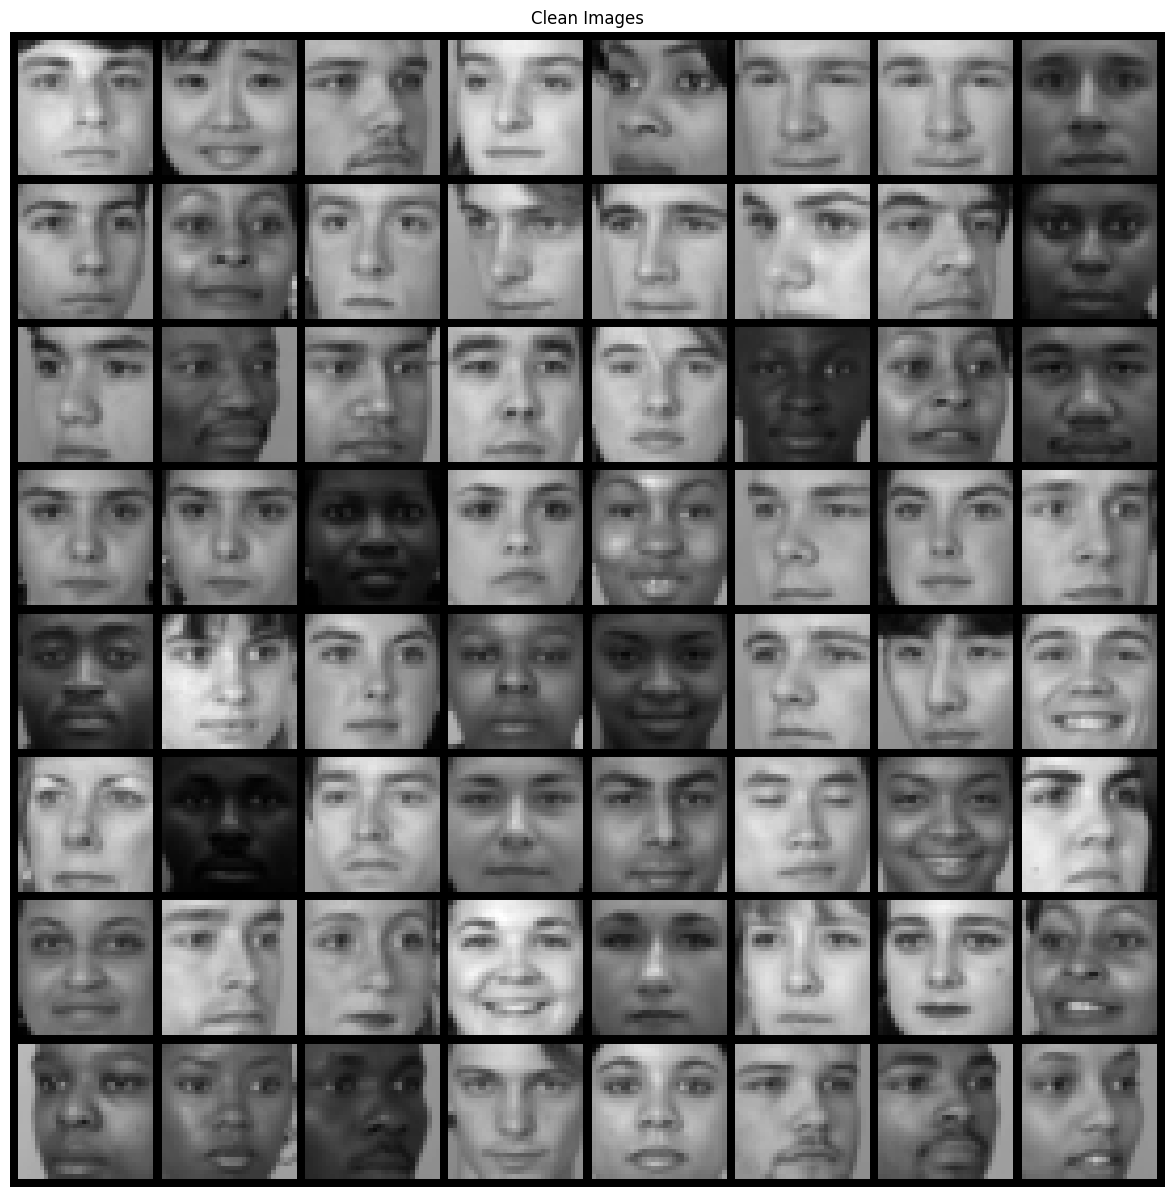

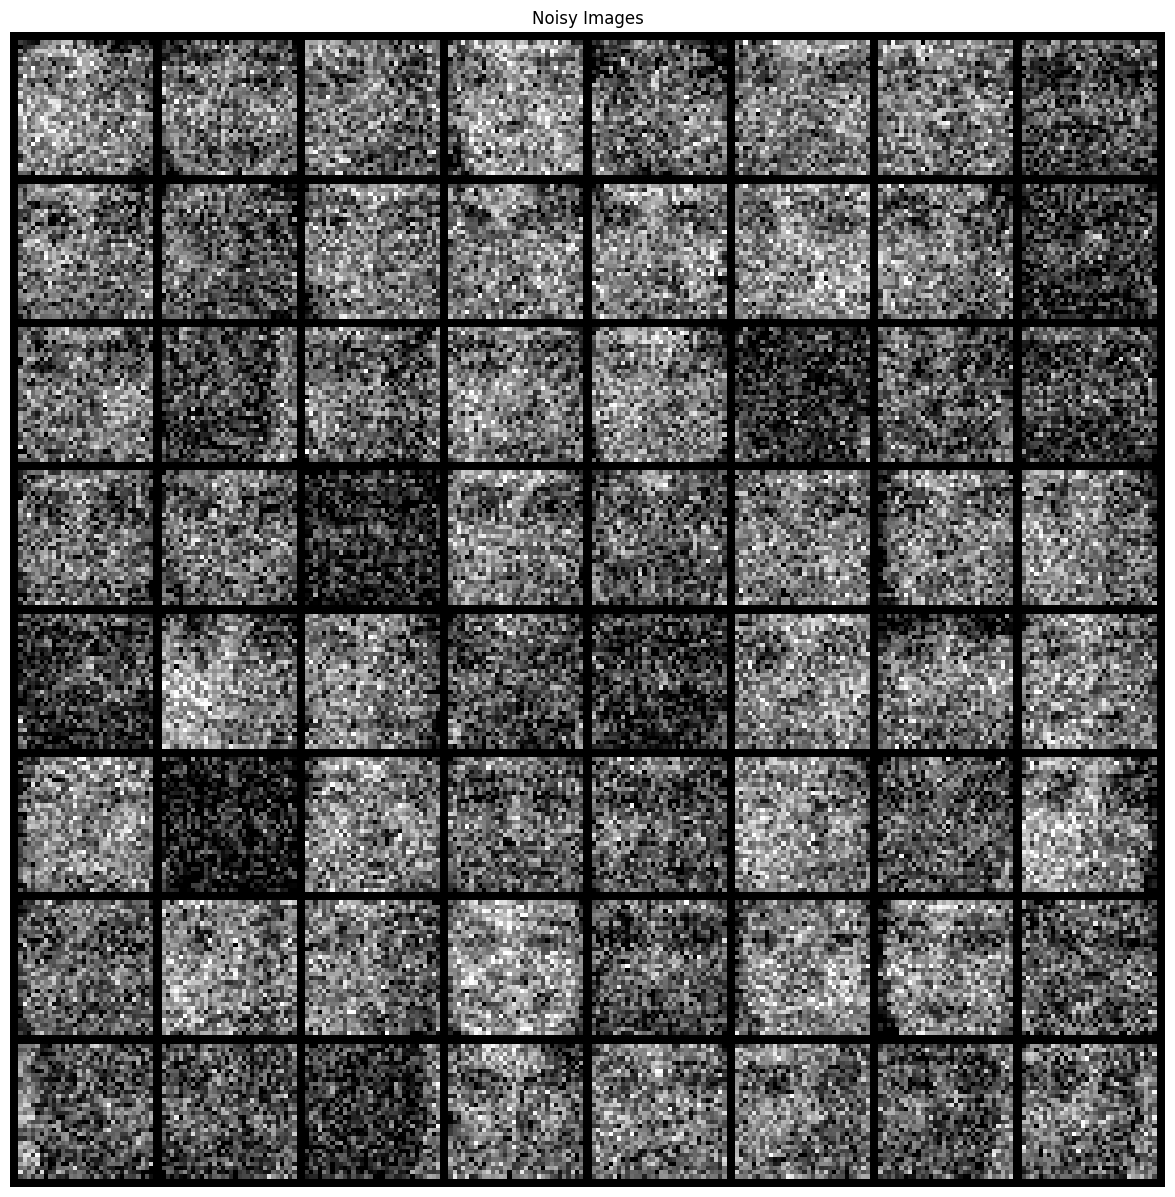

In [75]:
# Create noisy samples by noise_percentage * torch.randn_like(data0). 
# You can use torch.randn_like(data) * noise_percentage to generate noise based around the data's distribution
# These will just be temporary noisy images. You will add in the noise during the training_step of your Simple_AE class later on.

_, data_clean = next(iter(train_loader))

# Create noisy data
noise_percentage = 0.2
noisy_data = data_clean + torch.randn_like(data_clean) * noise_percentage
noisy_data = torch.clip(noisy_data, 0, 1) # Clip the data between 0 and 1. Look at the documentation for torch.clip()


def show_image_grid(images, title):
    grid = torchvision.utils.make_grid(images, nrow=8, normalize=True)
    plt.figure(figsize=(15, 15))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

# visualize clean dataset using torchvision grid
show_image_grid(data_clean, "Clean Images")

# visualize noisy dataset using torchvision grid
show_image_grid(noisy_data, "Noisy Images")

<div class="alert alert-block alert-info">
    
### Task 2.2: Design your network architecture for AE <a class="anchor" id="t2_2"></a>

In this task, you will create the encoder and decoder modules that you will use within your "Simple_AE" class (which will be your DAE).

The encoder will just consist of one layer with an activation function. BatchNorm1d will also be added to the encoder to speed up convergence. The decoder will also be one layer but has no activation function. You do not need to put a BatchNorm1d here.

The rest of the hyperparameters can be found within the PDF.

_Note: We have provided additional optional material in the weekly lectures for batch normalization if you wish to learn more about it. This is a useful technique in speeding up training. To use BatchNorm1d, you simply have to put in the previous layer's number of input features as the input parameter. See the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) for more information._

In [44]:
# Define your encoder class
# You will use one linear layer in the encoder class and pass it through BatchNorm1d() then LeakyReLU

class Encoder(nn.Module):    
    def __init__(self):
        super().__init__()
        # Encoder section

        # Define linear layer
        # Data resized in transform
        input_size = 32 * 32
        hidden_size = 128
        self.encoder = nn.Sequential(
            # Add Linear Layer
            nn.Linear(input_size, hidden_size),
            # Add BatchNorm1d() as the next one in the sequence. 
            nn.BatchNorm1d(hidden_size),
            # Then add LeakyReLU. Note BatchNorm1d takes an input argument.
            nn.LeakyReLU()
        )
        
    def forward(self, x):
        # Forward pass of your encoder
        #flatten
        x = x.view(x.size(0), -1)
        return self.encoder(x)
    
# Define your decoder class
# You will use one linear layer in the encoder class. No need for LeakyReLU because we have a sigmoid at the end

class Decoder(nn.Module):   
    def __init__(self):
        super().__init__()
        
        # Add Linear Layer
        output_size  = 32 * 32
        hidden_size = 128
        # Decoder section
        self.decoder = nn.Sequential(
            # Add Linear Layer
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x):
        # Forward pass through your decoder        
        # Pass the output of your decoder into a sigmoid function
        # Ensure you reshape to B x C x H x W before returning the values
        x = self.decoder(x)
        
        x = torch.sigmoid(x)
        #reshape
        return x.view(-1, 1, 32, 32)

Create your autoencoder class '_Simple_AE_' using LightningModule and call the Encoder and Decoder Blocks you have defined above.

In [45]:
#Let's create a simple DAE based on MLP networks
class Simple_AE(pl.LightningModule):
    
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.weight_decay = 1e-5
        self.learning_rate = learning_rate  # Use learning rate provided
        #MSE commonly used for images 
        self.loss_fn = nn.MSELoss()  # Define your loss
        
        self.encoder = Encoder()  # Initialise your encoder 
        self.decoder = Decoder()  # Initialise your decoder
        
    def forward(self, x):
        # Forward pass through encoder and decoder
        # Is the result the same shape as your original image? Worth to double check!
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def training_step(self, batch, batch_idx):  # There are additional steps here compared to previous implementations of your NN models. Read the comments carefully!
        x, y = batch  # Retrieve image from batch
        noisy_x  = x + torch.randn_like(x) * 0.2  # Add in noise to your data here
        noisy_x = torch.clip(noisy_x,0,1) #Clip your data between 0 and 1. You can use torch.clip()
        
        pred = self(noisy_x)  # Remember, this is where we are training. So you will pass in your noisy_data to the encoder, and use that latent code to pass through your decoder
    
        loss = self.loss_fn(pred, x) # Think about what your loss should be comparing against. There are 3 possibilities: original "x", predicted "x", and noisy "x". Which two are correct to predict?
                                        # If your model is not converging to a non-noisy output, this loss loss_fn might be why! (perhaps comparing two wrong values)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss # Don't forget to return loss so that the gradients can be updated
    
    def validation_step(self, batch, batch_idx):  # There are additional steps here compared to previous implementations of your NN models. Read the comments carefully!
        x , y = batch  # Validation step is very similar to the training_step
        noisy_x  = x + torch.randn_like(x) * 0.2  # Add in noise to your data here
        noisy_x = torch.clip(noisy_x,0,1) #Clip your data between 0 and 1. You can use torch.clip()
        
        
        # Remember, this is where we are validating. So you will pass in your noisy_data to the encoder, and use that latent code to pass through your decoder
        pred = self(noisy_x)  

        loss = self.loss_fn(pred, x)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        
    def test_step(self, batch, batch_idx):  # There are additional steps here compared to previous implementations of your NN models. Read the comments carefully!
        x,y = batch # Test step is similar to the validation step
        noisy_x  = x + torch.randn_like(x) * 0.2
        noisy_x = torch.clip(noisy_x,0,1)
        # Remember, this is where we are testing. So you will pass in your noisy_data to the encoder, and use that latent code to pass through your decoder
        pred = self(noisy_x)
        loss = self.loss_fn(pred, x)
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        
    
    def predict_step(self, batch, batch_idx):  # There are additional steps here compared to previous implementations of your NN models. Read the comments carefully!
        x,y = batch
        noisy_x  = x + torch.randn_like(x) * 0.2
        noisy_x = torch.clip(noisy_x,0,1)
        # You need to return predicted "x", noisy "x", and original x. That way you can compare the results with what is expected  ! 
        pred = self(noisy_x)
        return pred, noisy_x, x  

    def configure_optimizers(self):
        optimiser = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        return optimiser

    #####################
    # DATA RELATED HOOKS
    #####################

    def train_dataloader(self):
        return train_loader
    
    def val_dataloader(self):
        return valid_loader

    def test_dataloader(self):
        return test_loader

<div class="alert alert-block alert-info">
    
### Task 2.3: Train your model and evaluate the DAE results <a class="anchor" id="t2_3"></a>

In [53]:
# Initialize the model
model_ae = Simple_AE()

# Define checkpoint callback function to save best model
checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints_task_2/",
        save_top_k=1,        # save the best model
        mode="min",
        every_n_epochs=1
    )

# Call the Trainer and train the model
trainer_task = pl.Trainer(
    accelerator="auto",
    #devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=50,
    callbacks=[TQDMProgressBar(), checkpoint_callback],
    logger=CSVLogger(save_dir="logs_task_2/"),
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [54]:
# Train the Simple AE model
trainer_task.fit(model_ae, train_loader, valid_loader)



  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | loss_fn | MSELoss | 0      | train
1 | encoder | Encoder | 131 K  | train
2 | decoder | Decoder | 132 K  | train
--------------------------------------------
263 K     Trainable params
0         Non-trainable params
263 K     Total params
1.054     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\cgreg\anaconda3\envs\ECE4179\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\cgreg\anaconda3\envs\ECE4179\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\cgreg\anaconda3\envs\ECE4179\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [55]:
# Test the model and report test accuracy and test loss
trainer_task.test(model_ae) 

c:\Users\cgreg\anaconda3\envs\ECE4179\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.003962862771004438
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.003962862771004438}]

Visiualise your experimental results. First, take a look at the accuracy for both training and validation. 

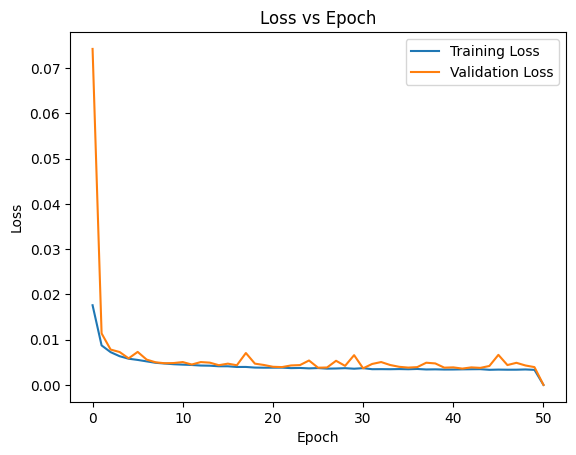

In [56]:
# Plot both training and validation losses
metrics_task_2 =  pd.read_csv("logs_task_2/lightning_logs/version_0/metrics.csv")
metrics_task_2.set_index("epoch", inplace=True)
metrics_task_2 = metrics_task_2.groupby(level=0).sum().drop("step", axis=1) 

plt.plot(metrics_task_2.index, metrics_task_2["train_loss"], label="Training Loss")
plt.plot(metrics_task_2.index, metrics_task_2["val_loss"], label="Validation Loss")

# Set plot title and labels
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


<div class="alert alert-block alert-info">
    
### Task 2.4: Visualise reconstructed images along with the clean data <a class="anchor" id="t2_4"></a>
    
Visualise some reconstructed images along with clean data and noisy data. You can use the predict function from your trainer. Reshape your output accordingly so that it is the same as the input image dimensions. Please plot at least 20 images, and make sure label your visualisations appropriately.

Predicting: |          | 0/? [00:00<?, ?it/s]

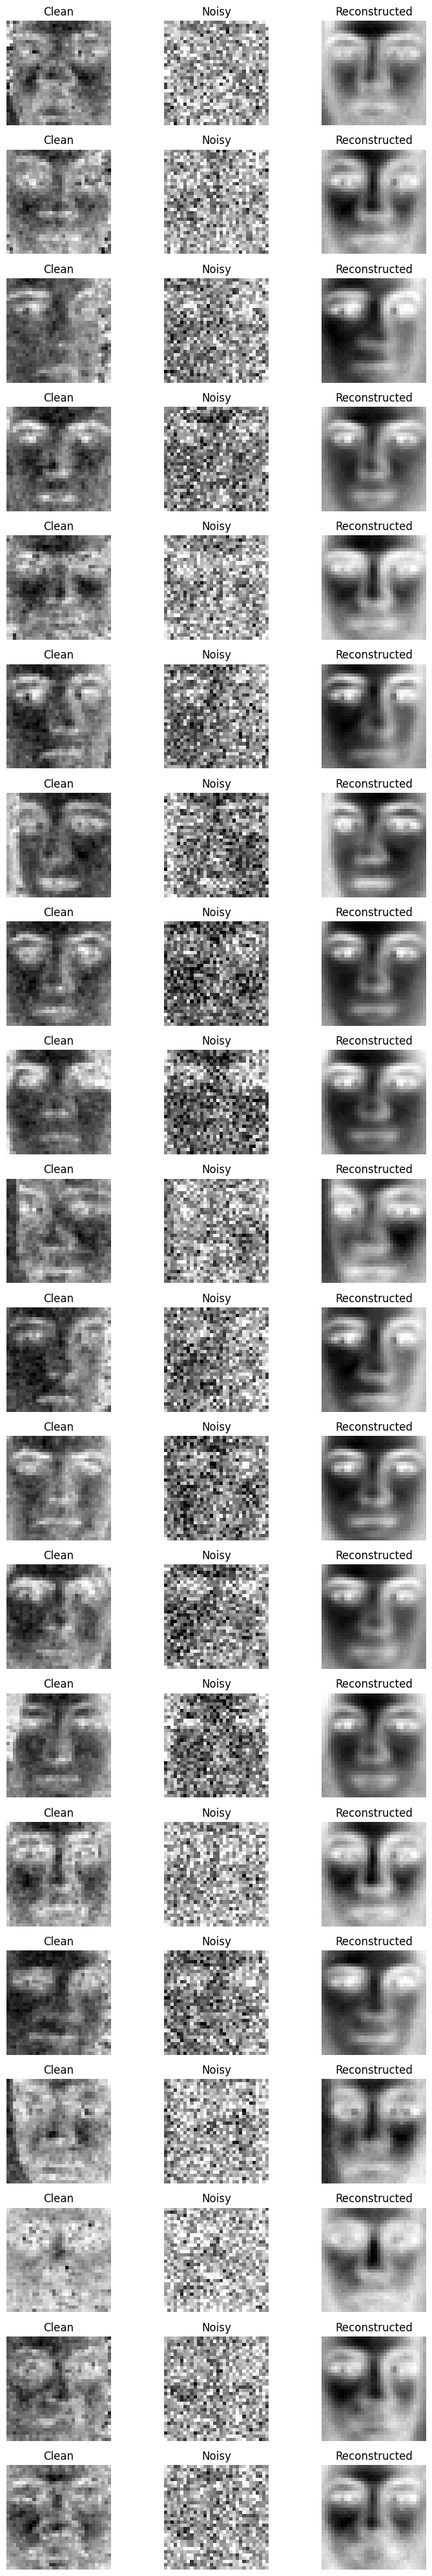

In [89]:
# Generate predictions using predict function
# Extract the predictions, noisy inputs, and clean inputs
predictions = trainer_task.predict(model_ae, test_loader)


pred = torch.concat([prediction[0] for prediction in predictions], dim=0)
noisy_x = torch.concat([prediction[1] for prediction in predictions], dim=0)
clean = torch.concat([prediction[2] for prediction in predictions], dim=0)


# visualize predictions along with noisy and clean input images using matplotlib

num_images = 20
fig, axes = plt.subplots(num_images, 3, figsize=(8, num_images * 2))


for i in range(num_images):
    # Plot clean image
    axes[i, 0].imshow(clean[i].squeeze(),cmap='gray')
    axes[i, 0].set_title("Clean")
    axes[i, 0].axis('off')
    
    # Plot noisy image
    axes[i, 1].imshow(noisy_x[i].squeeze(),cmap='gray')
    axes[i, 1].set_title("Noisy")
    axes[i, 1].axis('off')
    
    # Plot reconstructed image
    axes[i, 2].imshow(pred[i].squeeze(),cmap='gray')
    axes[i, 2].set_title("Reconstructed")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
    
### Task 2.5: Peak Signal To Noise Ratio (PSNR) <a class="anchor" id="t2_5"></a>
    
Here, you need to Compute Peak Signal-to-Noise Ratio (PSNR) for test dataset. The PSNR is a commonly used metric to measure the quality of a reconstructed or denoised signal or image. The PSNR is calculated as the ratio of the peak signal power to the noise power, typically measured in decibels (dB). PSNR can be defined as </br>
</br>
    $$\mathrm{PSNR} = 10 \cdot \log_{10}\Big\lbrace\frac{{\mathrm{MAX}^2}}{{\mathrm{MSE}}}\Big\rbrace$$

Where:

`PSNR` is the Peak Signal-to-Noise Ratio in dB.

`MAX` is the maximum possible pixel value (e.g., 255 for an 8-bit image).

`MSE` is the Mean Squared Error between the original and the reconstructed (or denoised) image. It's calculated as the average of squared pixel-wise differences between the two images.

Show the PSNR values for:
- Between the noisy image and original image
- Between the reconstructed image and original image

In [91]:
from torchmetrics.image import PeakSignalNoiseRatio

psnr = PeakSignalNoiseRatio()

# Put model into eval() mode so it turns off batch norm
model_ae.eval() 

# Collect predictions and true labels
psnr_values_noisy_n_original = []
psnr_values_reconstructed_n_original = []

# Iterate over the entire test dataset and make predictions
# Make sure to use torch.no_grad below so that it does not keep track of gradients
with torch.no_grad():
    for batch in test_loader:
        noisy_images, clean_images = batch
        reconstructed_images = model_ae(noisy_images)

        psnr_values_noisy_n_original.append(psnr(noisy_images, clean_images).item())
        psnr_values_reconstructed_n_original.append(psnr(reconstructed_images, clean_images).item())
        
print(f"Mean PSNR value between noisy image and original image: {np.mean(psnr_values_noisy_n_original)}")
print(f"Mean PSNR value between reconstructed image and original image: {np.mean(psnr_values_reconstructed_n_original)}")

Mean PSNR value between noisy image and original image: 7.939300696055095
Mean PSNR value between reconstructed image and original image: 7.950374921162923


<div class="alert alert-block alert-success">
    
### Task 2.6: Discussion Question <a class="anchor" id="t2_6"></a>
    
### Question:

1. How does the DAE reduce the amount of noise from the input?

2. Can you think of a reason why leaky ReLU was chosen over ReLU in this case?

3. What can you say about the PSNR values? Ensure you mention whether higher or lower PSNR values are better. 

4. How could we further improve the model? 
    
### Answer

1. The encoder reduces the dimensionality of the noisy input and captures the important features in a lower-dimensional latent space. The decoder then learns through training to decode it in such a way that it reduces the noise. Adding noise to the training data allows the model to learn not to be overly sensitive to random variations.

2. Since noisy data may have variations that lead to negative activation values, using ReLU could cause the gradients to vanish, making the model less effective at capturing and transforming subtle patterns in the noisy data. Leaky ReLU allows some gradient to flow (even if it is small).

3. Given that your PSNR value is only marginally higher than the noisy PSNR value, it implies that the autoencoder is not learning to distinguish noise from the original image features effectively. The higher the PSNR the better in this case.
 
4. Improvements could include:
- Adding a convolutional layer could help the model capture patterns in the image and potentially help learn the more complex transformions
- Increasing the model depth to the encoder and decoder could help also